In [106]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import os, sys
import numpy as np
import pandas as pd
from scipy import io, stats
from seaborn import despine

sys.path.append('../')
import echo_utils

font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('image', cmap='inferno')

C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig_path = '../figures/mni/%s.pdf'
save_plot=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
# load data
d_query = 4
df_W_max = pd.read_csv('../data/df_human_W_max_%i.csv'%d_query, index_col=0)
df_tau_weighted = pd.read_csv('../data/df_human_tau_weighted_%i.csv'%d_query, index_col=0)
df_struct = pd.read_csv('../data/df_structural.csv', index_col=1)
df_ecog = pd.read_csv('../data/df_human.csv', index_col=0)
mmp_aggr = pd.read_csv('../data/mmp_macro.csv', index_col=0, names=['parcel','macro_region'])

# get patient info for age-related analysis
df_patient = df_ecog.groupby('patient').mean()[['gender', 'age']].astype(int)
df_patient.index = df_patient.index.astype(int)

# Plot individual subject and aggregate coverage maps on MMP

colormap sequential: [0.00e+00, 1.40e+01, 2.80e+01] (opaque)


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


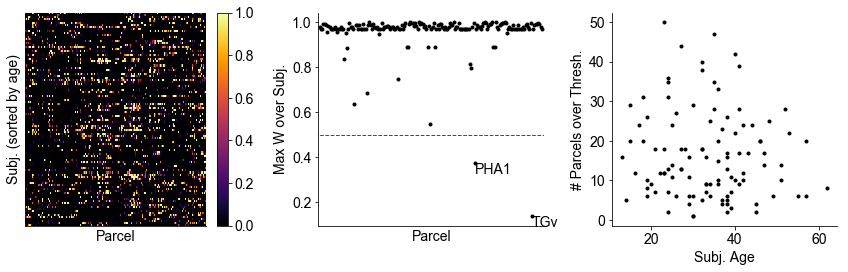

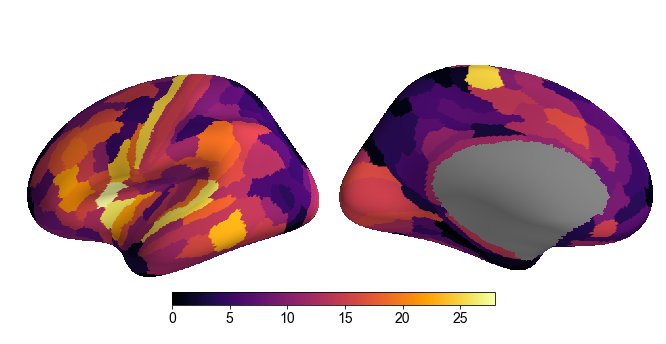

In [108]:
plot_subj_coverage = False
subj_fig_path = '../figures/mni/subj_mmp_coverage/'
if plot_subj_coverage:
    # plot aggregate max
    echo_utils.plot_MMP(np.max(df_W_max.values, axis=0), subj_fig_path+'aggregate')

    # plot individual subject map
    for s_i, s in df_W_max.iterrows():
        echo_utils.plot_MMP(s.values, subj_fig_path+'subj_%i'%int(s_i))
        
# different visualization of coverage 
w_thres = 0.5

plt.figure(figsize=(12,4))

# heat map of weight matrix (subj x parcel)
plt.subplot(1,3,1)
plt.imshow(df_W_max.values[np.argsort(df_patient['age']).values.astype(int),:], aspect='auto')
plt.xlabel('Parcel');plt.ylabel('Subj. (sorted by age)')
plt.xticks([]);plt.yticks([]); plt.colorbar()

# maximum weight in each parcel, pooled over subjects
plt.subplot(1,3,2)
region_wmax = np.max(df_W_max.values,axis=0)
plt.plot(region_wmax, 'k.')
plt.plot(plt.xlim(),[w_thres, w_thres], 'r--', lw=1)
plt.xlim([-1,len(region_wmax)+1])
plt.xlabel('Parcel');plt.ylabel('Max W over Subj.')
plt.xticks([]); despine()
under_w_thresh = np.where(region_wmax<w_thres)[0]
for w in under_w_thresh:
    plt.text(w, region_wmax[w], df_W_max.columns[w], verticalalignment='top')

# # of confident parcels per subject, sorted by age
plt.subplot(1,3,3)
plt.plot(df_patient['age'], np.sum(df_W_max>=w_thres,1),'.k')
plt.xlabel('Subj. Age');plt.ylabel('# Parcels over Thresh.')
despine()
    
plt.tight_layout()
if save_plot: plt.savefig(fig_path%'mni_mmp_coverage')

# percentage of patients that had coverage at that parcel
pct_coverage = (df_W_max>w_thres).sum(axis=0)
plt.figure(figsize=(10,5))
echo_utils.plot_MMP(pct_coverage, save_file=fig_path%'mmp_coverage', bp=2)

# Tau-Expression Correlation

In [109]:
def compute_weighted_average(df_feature, df_W, w_thresh=0.5, axis=0, method='weighted'):
    if method is 'weighted':
        # method 1: weighted average of all parcels 
        #    this makes the most sense? weights all parcels, and the non-confident ones are already downweighted
        return (df_feature*df_W).sum(axis=axis)/df_W.sum(axis=axis)

    elif method is 'thresh_weighted':
        # method 2: weighted average of suprathreshold parcels
        #    this will approach method 1 as w_thresh approaches 0
        thresh_mat = df_W>=w_thres
        return (df_feature*df_W)[thresh_mat].sum(axis=axis)/df_W[thresh_mat].sum(axis=axis)
    
    elif method is 'thresh_mean':
        # method 3: simple average of suprathreshold parcels
        #    not sure if it makes sense to weight all suprathreshold parcels equally
        thresh_mat = df_W>=w_thres
        return np.nanmean((df_feature*df_W)[thresh_mat],axis=axis)

colormap sequential: [1.07e+00, 1.40e+00, 1.72e+00] (opaque)


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


colormap sequential: [0.00e+00, 2.50e-02, 5.00e-02] (opaque)


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


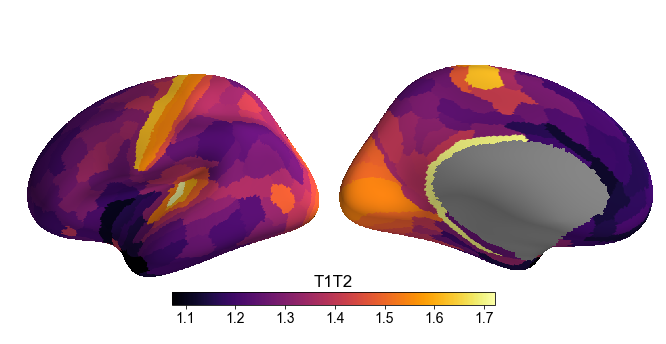

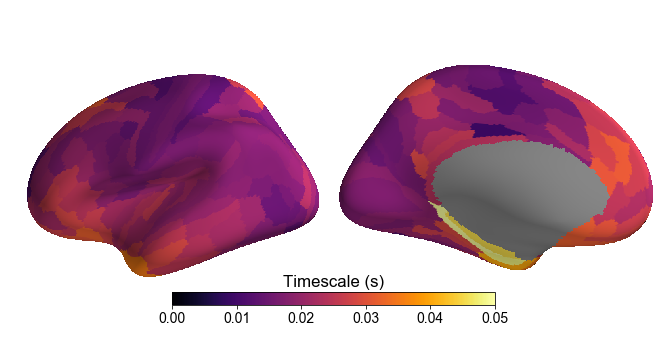

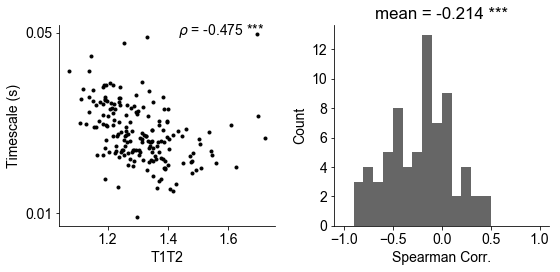

In [386]:
xy_axis_frac = (0.55, 0.95)
struct_feat = 'T1T2'
# plot feature on MMP brain
plt.figure(figsize=(10,5))
echo_utils.plot_MMP(df_struct[struct_feat].values, save_file=fig_path%('mmp_'+struct_feat), bp=2)
plt.title(struct_feat)

df_tau_threshed = df_tau_weighted[df_W_max>=w_thres]
tau_parcel = compute_weighted_average(df_tau_weighted, df_W_max, w_thres, method='weighted')

# plot grand average value on MMP
plt.figure(figsize=(10,5))
echo_utils.plot_MMP(tau_parcel, save_file=fig_path%'mmp_tau', minmax=[0,0.05], bp=2)
plt.title('Timescale (s)')

# group average correlation
rho, pv = stats.spearmanr(df_struct[struct_feat], tau_parcel, nan_policy='omit')

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(df_struct[struct_feat], tau_parcel, '.k')
plt.yscale('log');
plt.xlabel(struct_feat); plt.ylabel('Timescale (s)'); despine()
plt.yticks([0.01, 0.05], ['0.01', '0.05']); plt.tick_params('y', which='minor', left=False, labelleft=False)
s = r'$\rho$ = %.3f '%rho + np.sum(pv<=np.array([0.05, 0.01, 0.005]))*'*'
plt.annotate(s, xy=xy_axis_frac, xycoords='axes fraction')

# per-subject correlation
min_parcels = 10
df_subj_corr = pd.DataFrame(index=df_tau_weighted.index, columns=['n_parcels', 'rho', 'pv'])
for i_s, subj in df_tau_threshed.iterrows():
    df_subj_corr['n_parcels'].loc[i_s] = (~np.isnan(subj)).sum()
    if df_subj_corr['n_parcels'].loc[i_s]>=3:
        rho, pv = stats.spearmanr(df_struct[struct_feat], subj, nan_policy='omit')
    else:
        rho, pv = np.nan, np.nan
    df_subj_corr['rho'].loc[i_s],df_subj_corr['pv'].loc[i_s] = rho,pv

# only count correlations from subjects that had min # of parcels
corr_valid = df_subj_corr[df_subj_corr['n_parcels']>=min_parcels]['rho'].values.astype(float)
tt_pv = stats.ttest_1samp(corr_valid, 0)[1]
plt.subplot(1,2,2)
plt.hist(corr_valid, bins=np.arange(-1,1.1,0.1), color='k', alpha=0.6)
plt.xlabel('Spearman Corr.');plt.ylabel('Count');despine()
s = 'mean = %.3f '%np.nanmean(corr_valid) + np.sum(tt_pv<=np.array([0.05, 0.01, 0.005]))*'*'
plt.title(s);
plt.tight_layout()
plt.savefig(fig_path[:-4]%('mmp_tau_%s_%i'%(struct_feat,d_query)), bbox_inches='tight')

# Correlation with gene expression

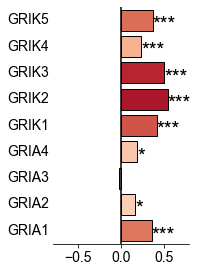

In [389]:
sig_thres = 0.01
df_tau_corr_all = pd.DataFrame(index=df_struct.columns[1:], columns=['rho', 'pv'])
for i_f, s_f in enumerate(df_struct.columns[1:]):
    rho, pv = stats.spearmanr(df_struct[s_f], tau_parcel, nan_policy='omit')
    df_tau_corr_all.loc[s_f] = rho, pv 
    
color = plt.cm.RdBu_r(np.linspace(0,1,200))

# genes
expr_ampa = df_tau_corr_all.index[45:49].values
expr_nmda = df_tau_corr_all.index[49:56].values
expr_kainate = df_tau_corr_all.index[66:71].values
expr_gaba = df_tau_corr_all.index[71:77].values
expr_inh = df_tau_corr_all.index[89:92].values

query_set = np.concatenate((expr_ampa, expr_kainate))
#query_set = expr_nmda
#query_set = np.concatenate((expr_gaba, expr_inh))

plt.figure(figsize=(3,4))
for i_f, s_f in enumerate(query_set):
    rho, pv = df_tau_corr_all.loc[s_f]
    plt.barh(i_f, rho, ec='k', fc=color[int((1+rho*1.5)*100)])
    s = np.sum(pv<=np.array([0.05, 0.01, 0.005]))*'*'
    plt.text(rho, i_f-0.4, s, fontsize=20, horizontalalignment='left' if rho>0 else 'right')

plt.plot([0,0], plt.ylim(), 'k')
plt.ylim([-0.5,len(query_set)-0.5])
plt.yticks(range(len(query_set)), query_set, rotation=0, ha='right', va='center', rotation_mode='anchor')
plt.tick_params(axis='y', which=u'both',length=0)
plt.xlim([-.8,.8])
despine(left=True);plt.tight_layout()
#plt.savefig(fig_path%'mni_all_corr',  bbox_inches='tight')
    

# Gene-PC vs. tau

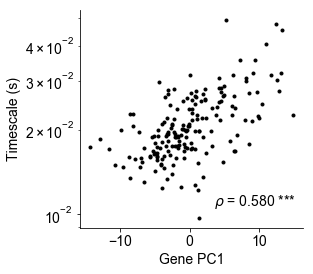

In [255]:
from sklearn import decomposition
gene_pca = decomposition.PCA(10)
gene_grad = gene_pca.fit_transform(np.array(df_struct)[:,2:])
rho,pv = stats.spearmanr(gene_grad[:,0], tau_parcel, nan_policy='omit')
plt.figure(figsize=(4,4))
plt.plot(gene_grad[:,0], tau_parcel, '.k')
plt.yscale('log')
plt.xlabel('Gene PC1'); plt.ylabel('Timescale (s)'); despine()
s = r'$\rho$ = %.3f '%rho + np.sum(pv<=np.array([0.05, 0.01, 0.005]))*'*'
plt.annotate(s, xy=(0.6,0.1), xycoords='axes fraction');


# Age-related Changes in Tau

### Median Age Split

Ttest_1sampResult(statistic=-0.8319861889407119, pvalue=0.4066645449111732)
colormap sequential: [-2.00e-02, 0.00e+00, 2.00e-02] (opaque)


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


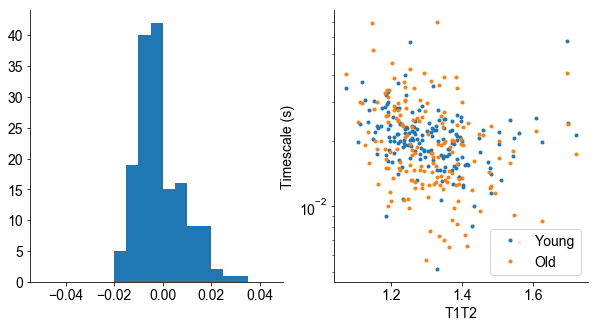

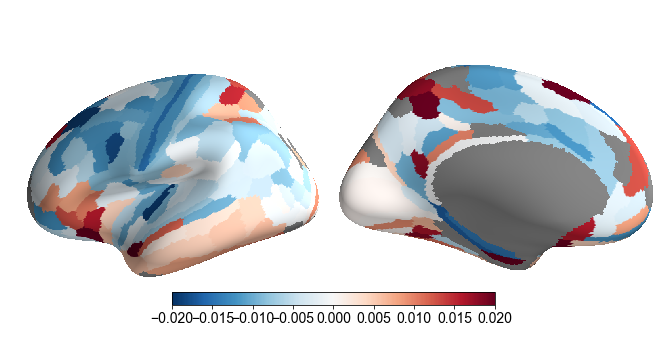

In [135]:
inds_young = df_patient['age']<df_patient['age'].median()
inds_old = df_patient['age']>=df_patient['age'].median()

tau_parcel_age = []
for inds in [inds_young, inds_old]:
    tau_parcel_age.append(compute_weighted_average(df_tau_weighted[inds], df_W_max[inds], w_thres, method='thresh_weighted'))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
tau_diff = (tau_parcel_age[1]-tau_parcel_age[0]).values
plt.hist(tau_diff[~np.isnan(tau_diff)], np.arange(-0.05,0.05,0.005))
print(stats.ttest_1samp(tau_diff, 0, nan_policy='omit'))

plt.subplot(1,2,2)
plt.plot(df_struct[struct_feat], tau_parcel_age[0], '.', label='Young')
plt.plot(df_struct[struct_feat], tau_parcel_age[1], '.', label='Old')
plt.yscale('log'); plt.legend()
plt.xlabel(struct_feat);plt.ylabel('Timescale (s)'); despine()

plt.figure(figsize=(10,5))
echo_utils.plot_MMP(tau_diff, save_file=fig_path%'mmp_taudiff_oldyoung', minmax=[-0.02,0.02], bp=2, cmap='RdBu_r')

### Average over electrodes per subject

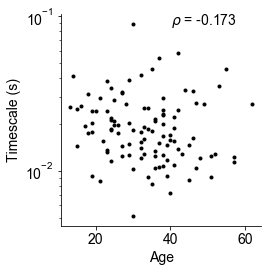

In [136]:
tau_subj = compute_weighted_average(df_tau_weighted, df_W_max, w_thres, method='weighted', axis=1)
rho, pv = stats.spearmanr(df_patient['age'], tau_subj, nan_policy='omit')
plt.figure(figsize=(4,4))
plt.plot(df_patient['age'], tau_subj, '.k')
plt.yscale('log');
plt.xlabel('Age'); plt.ylabel('Timescale (s)'); despine()
s = r'$\rho$ = %.3f '%rho + np.sum(pv<=np.array([0.05, 0.01, 0.001]))*'*'
plt.annotate(s, xy=xy_axis_frac, xycoords='axes fraction')
plt.tight_layout()


# Correlation of Tau & Age By Region

### By Parcel

colormap sequential: [-7.50e-01, 0.00e+00, 7.50e-01] (opaque)


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


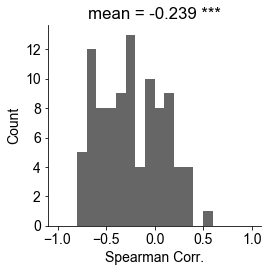

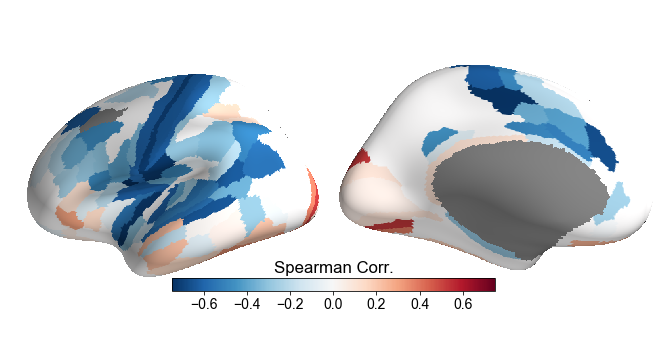

In [375]:
# minimum number of subjects that passed threshold in a parcel to include parcel
min_subjs = 8
df_age_corr=pd.DataFrame(index=df_tau_weighted.columns, columns=['n_subjs', 'rho', 'pv'])
for parcel, col in df_tau_threshed.iteritems():
    df_age_corr['n_subjs'].loc[parcel] = (~np.isnan(col)).sum()
    if df_age_corr['n_subjs'].loc[parcel]>=3:
        rho, pv = stats.spearmanr(df_patient['age'], col, nan_policy='omit')
        df_age_corr['rho'].loc[parcel], df_age_corr['pv'].loc[parcel] = rho, pv
    else:
        df_age_corr['rho'].loc[parcel], df_age_corr['pv'].loc[parcel] = np.nan, np.nan
        
# only count correlations from parcels that had min # of subjs
parcel_corr = df_age_corr['rho']
parcel_corr[df_age_corr['n_subjs']<=min_subjs]=np.nan

plt.figure(figsize=(4,4))
plt.hist(parcel_corr.values.astype(float), bins=np.arange(-1,1.1,0.1), color='k', alpha=0.6)
tt_pv = stats.ttest_1samp(parcel_corr.values.astype(float), 0, nan_policy='omit')[1]
plt.xlabel('Spearman Corr.');plt.ylabel('Count');despine()
s = 'mean = %.3f '%np.nanmean(parcel_corr.values) + np.sum(tt_pv<=np.array([0.05, 0.01, 0.005]))*'*'
plt.title(s);
plt.tight_layout()
plt.savefig(fig_path[:-4]%('mmp_parcel_agecorr_dist_%i'%(d_query)), bbox_inches='tight')

parcel_corr[df_age_corr['n_subjs']<=min_subjs]=0
plt.figure(figsize=(10,5))
echo_utils.plot_MMP(parcel_corr.values, fig_path%'mmp_parcel_agecorr', minmax=[-.75,.75], cmap='RdBu_r')
plt.title('Spearman Corr.');

### By Glasser Macro Regions (21)

In [193]:
# aggregating by macro region
df_tau_macro = pd.DataFrame(columns=np.unique(mmp_aggr['macro_region']))
df_struct_macro = pd.DataFrame(columns=np.unique(mmp_aggr['macro_region']))
for i_r, r in mmp_aggr.groupby('macro_region'):
    df_tau_macro[i_r] = compute_weighted_average(df_tau_weighted[r['parcel']], df_W_max[r['parcel']], axis=1, method='thresh_weighted')
    df_struct_macro[i_r] = df_struct.loc[r['parcel']].mean(axis=0)
    
df_struct_macro = df_struct_macro.T
df_tau_macro_mean = df_tau_macro.mean(0)

['dlpfc' 'ifc' 'mpfc_acc' 'ofc']


SpearmanrResult(correlation=-0.2335185688272608, pvalue=0.07254335481257278)

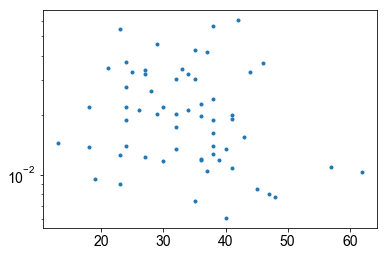

In [352]:
print(np.unique(mmp_aggr['macro_region'])[[2,3,8,9]])
frontal_regions = np.unique(mmp_aggr['macro_region'])[[2,3,8,9]]
frontal_inds = []
for reg in frontal_regions:
    frontal_inds.append(mmp_aggr[(mmp_aggr['macro_region']==reg)].index.values)

frontal_inds = np.sort(np.hstack(frontal_inds))
tau_frontal = compute_weighted_average(df_tau_weighted[mmp_aggr.loc[frontal_inds]['parcel']], 
                                       df_W_max[mmp_aggr.loc[frontal_inds]['parcel']], 
                                       axis=1, method='thresh_weighted').values

plt.plot(df_patient['age'], tau_frontal, '.')
plt.yscale('log')
stats.spearmanr(df_patient['age'], tau_frontal, nan_policy='omit')




SpearmanrResult(correlation=-0.6402597402597403, pvalue=0.001769793050350851)

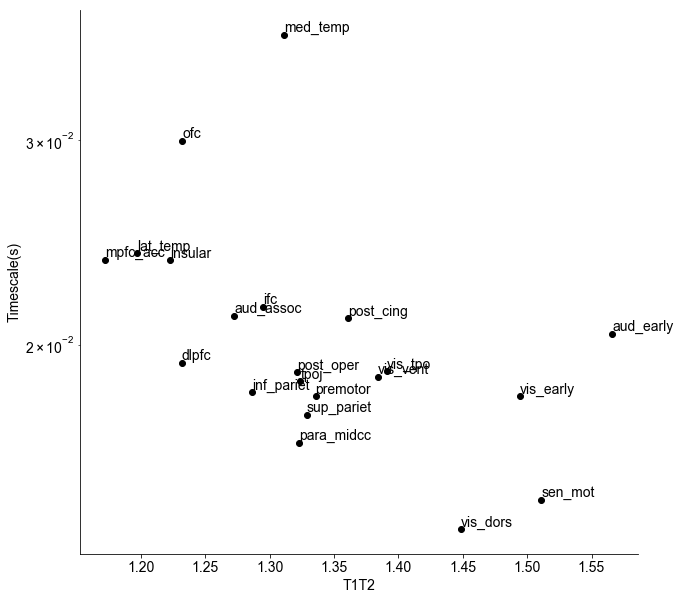

In [257]:
# macro-region level correlation
struct_feat = 'T1T2'
plt.figure(figsize=(10,10))
plt.plot(df_struct_macro[struct_feat],df_tau_macro_mean, 'ok')
for mr in df_struct_macro.index:
    plt.annotate(mr, (df_struct_macro.loc[mr][struct_feat], df_tau_macro_mean[mr]), 
                 horizontalalignment='left', verticalalignment='bottom')
    
plt.yscale('log'); 
plt.xlabel(struct_feat); plt.ylabel('Timescale(s)');despine()
stats.spearmanr(df_struct_macro[struct_feat],df_tau_macro.mean(0), nan_policy='omit')

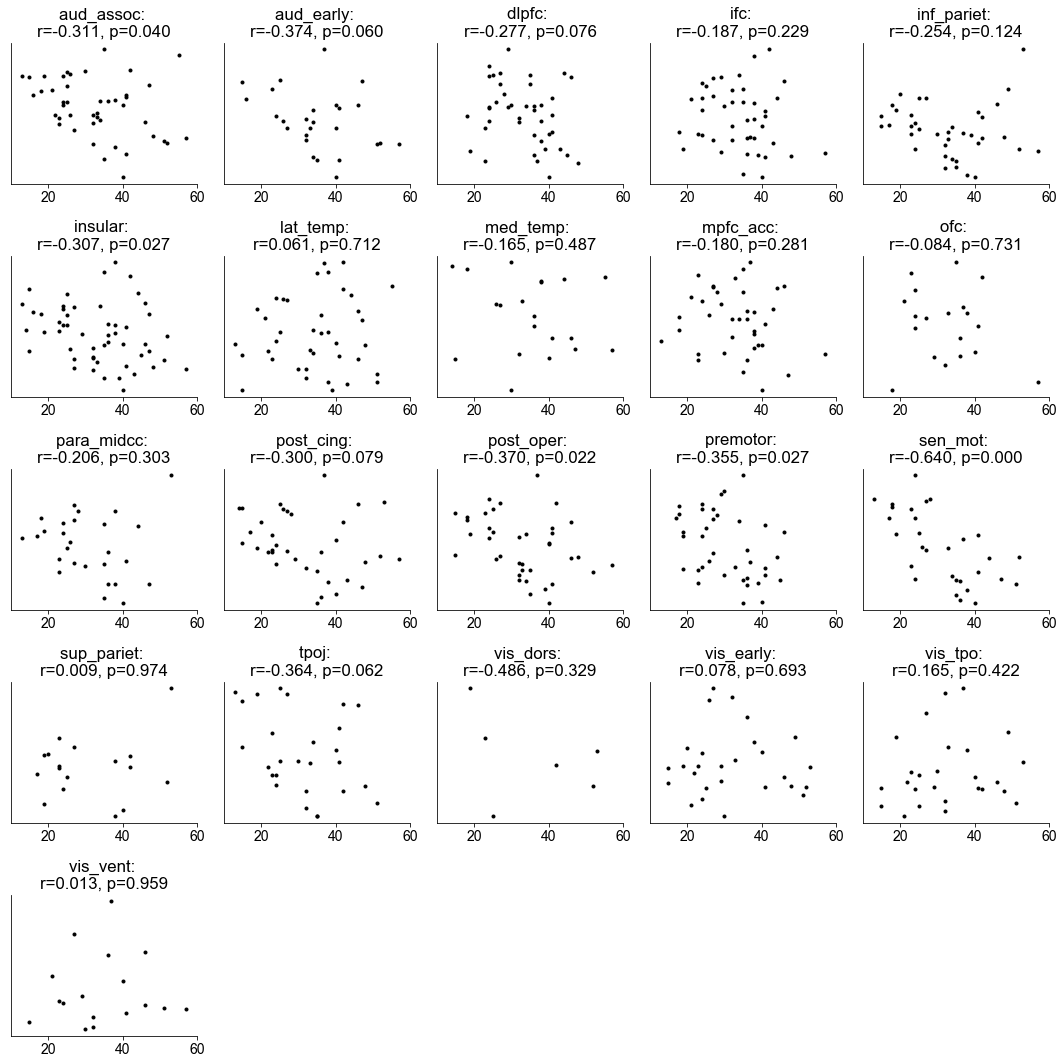

In [168]:
# age correlation
plt.figure(figsize=(15,15))
for i_r, r in enumerate(df_tau_macro.columns):
    plt.subplot(5,5,i_r+1)
    plt.plot(df_patient['age'], df_tau_macro[r], '.k')
    rho,pv = stats.spearmanr(df_patient['age'], df_tau_macro[r], nan_policy='omit')
    plt.yscale('log')
    plt.xlim([10,60]); despine()
    plt.tick_params(axis='y', which='both', left='off', labelleft='off')
    plt.title('%s: \nr=%.3f, p=%.3f'%(r,rho,pv))

plt.tight_layout()

### By Quantiles of T1T2 (Cortical Hierarchy)

colormap sequential: [0.00e+00, 1.50e+00, 3.00e+00] (opaque)


/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


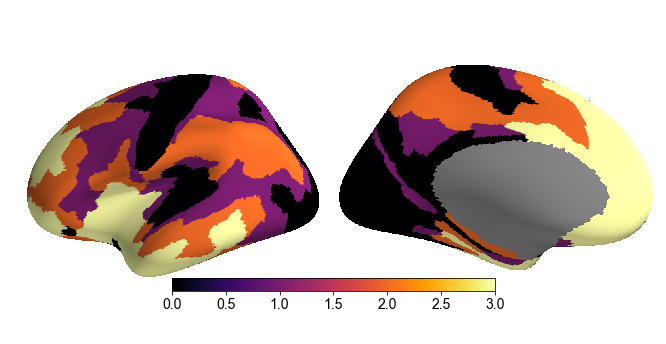

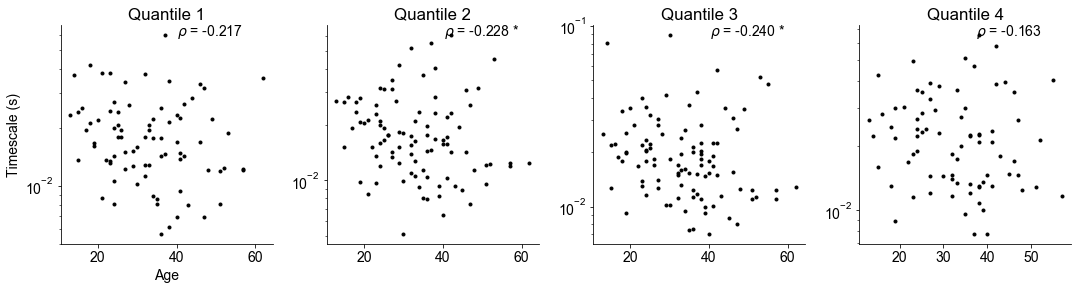

In [355]:
# label the parcels based on quantile of T1T2 value
quants = 4
struct_feat = 'T1T2'
parcels_quant = quants-np.digitize(df_struct[struct_feat], np.quantile(df_struct[struct_feat], np.arange(0,1,1/quants)))
plt.figure(figsize=(10,5))
echo_utils.plot_MMP(parcels_quant, fig_path[:-4]%('mmp_'+struct_feat+'_quantile'))

plt.figure(figsize=(15,4))
for quant in range(quants):
    plt.subplot(1,quants,quant+1)
    # weighted sum
    tau_avg = compute_weighted_average(df_tau_weighted.T[parcels_quant==quant], df_W_max.T[parcels_quant==quant], w_thres, method='thresh_weighted')

    rho, pv = stats.spearmanr(df_patient['age'], tau_avg, nan_policy='omit')
    plt.plot(df_patient['age'], tau_avg, 'k.')
    s = r'$\rho$ = %.3f '%rho + np.sum(pv<=np.array([0.05, 0.01, 0.001]))*'*'
    plt.annotate(s, xy=xy_axis_frac, xycoords='axes fraction')
    plt.yscale('log'); despine()
    plt.title('Quantile %i'%(quant+1))

plt.tight_layout()
plt.subplot(1,quants,1); plt.xlabel('Age'); plt.ylabel('Timescale (s)')
plt.savefig(fig_path[:-4]%('mmp_tau_age_quantile%i'%(d_query)), bbox_inches='tight')


### Group by age

In [296]:
age_bins = np.arange(20,70,10)
df_tau_age_grp = pd.DataFrame(index=age_bins, columns=df_tau_weighted.columns)
age_grp = np.digitize(df_patient.age.values, age_bins[:-1])
df_patient['age_group']=age_grp
for age, group in df_patient.groupby('age_group'):
    df_tau_age_grp.loc[age_bins[age]] = compute_weighted_average(df_tau_weighted.loc[group.index], df_W_max.loc[group.index], w_thres, method='thresh_weighted')

df_tau_age_grp


,V1,MST,V6,V2,V3,V4,V8,4,3b,FEF,...,p47r,TGv,MBelt,LBelt,A4,STSva,TE1m,PI,a32pr,p24
20,0.0146072,0.0126074,NaN,0.0139693,0.0139735,NaN,NaN,0.0216812,0.0217871,0.0246265,...,0.011351,NaN,0.0323788,0.031566,0.0259861,0.0338098,0.0307168,0.0249202,0.0289377,NaN
30,0.0126562,0.0109717,NaN,0.0180221,0.01233,0.0173693,NaN,0.019259,0.0211493,0.0179652,...,0.0278832,NaN,0.0237848,0.0251886,0.0203748,0.0263922,0.0243563,0.0224703,0.0411189,0.0372159
40,0.0275825,NaN,NaN,0.0347686,0.018971,0.0280518,0.0081573,0.00790446,0.00937638,0.00827379,...,0.0296098,NaN,0.0136168,0.0226066,0.0177721,0.0208562,0.0190956,0.0231447,0.0302651,0.0369148
50,0.0150091,0.0123987,NaN,0.0166994,0.0208196,0.0153812,0.0119134,0.0102782,0.0115341,NaN,...,0.0361083,NaN,0.0188427,0.0229293,0.0167192,0.0198327,0.0305416,0.0153103,0.0232156,0.0120466
60,0.0173325,NaN,0.0115528,0.0188035,0.0260086,0.0325026,NaN,0.00766021,0.0075667,NaN,...,0.00966893,NaN,0.0130565,0.0124724,0.010809,0.0376447,0.01103,0.0140653,0.0113643,NaN


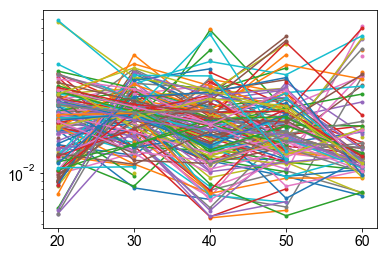

In [370]:
plt.plot(df_tau_age_grp, '.-');
plt.yscale('log')
rho=[]
for reg, col in df_tau_age_grp.iteritems():
    rho.append(stats.spearmanr(col, age_bins)[0])

rho=np.array(rho)